In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [46]:
climate_data = pd.read_csv('./asos003_SQM_ACCESS-CM2_ssp585.csv')
climate_data['YR'] = [str(x) for x in climate_data['YR']]
climate_data['MM'] = [str(x).zfill(2) for x in climate_data['MM']]
climate_data['DD'] = [str(x).zfill(2) for x in climate_data['DD']]

climate_data = climate_data.groupby(by=['YR', 'MM']).sum()
climate_data = climate_data.reset_index()
climate_data['YMD'] = climate_data['YR'] + '-' + climate_data['MM']
climate_data = climate_data.drop(columns=['YR', 'MM'])
climate_data.index = pd.to_datetime(climate_data['YMD'])

climate_data = climate_data[['PCP']].copy()
climate_data_F1 = climate_data.loc[climate_data.index <= '2039-12-01', :]
climate_data_F2 = climate_data.loc[(climate_data.index >= '2040-01-01') & (climate_data.index <= '2069-12-01'), :]
climate_data_F3 = climate_data.loc[(climate_data.index >= '2070-01-01') & (climate_data.index <= '2100-12-01'), :]

In [56]:
climate_data = pd.read_csv('./OBS_ASOS_MNH_20231101105436.csv', encoding='cp949')
climate_data = climate_data[['일시', '월합강수량(00~24h만)(mm)']]
climate_data.columns = ['YMD', 'PCP']
climate_data.index = pd.to_datetime(climate_data['YMD'])
climate_data = climate_data.drop(columns=['YMD'])

In [47]:
#Standardized Precipitation Index Function
def spi(ds, thresh):
    
    ds_ma = ds.rolling(thresh, center=False).mean() #thresh만큼 이동평균
    
    ds_In = np.log(ds_ma) # gamma 분포의 파라미터 추정을 위해 log 변환
    ds_In[np.isinf(ds_In) == True] = np.nan # inf가 있는 경우 NaN으로 대체 -> log 변환시 0과 같은 값은 inf 발생
    
    ds_mean = np.nanmean(ds_ma) # NaN를 제외한 전체 기간에 대한 평균
    
    ds_sum = np.nansum(ds_In) # 로그 변환된 값에 대해 NaN을 제외한 전체 기간에 대한 합
        
    #Computing essentials for gamma distribution
    n = len(ds_In[thresh-1:])                  # 지속기간별 데이터 길이
    A = np.log(ds_mean) - (ds_sum/n)           # alpha를 구하기 위한 A 계산
    alpha = (1/(4*A))*(1+(1+((4*A)/3))**0.5)   # gamma 분포의 파라미터 alpha 계산 : 
    beta = ds_mean/alpha                       # gamma 분포의 beta 계산
    
    # alpha, beta : gamma 분포를 구하기 위한 파라미터 
    
    gamma = st.gamma.cdf(ds_ma, a=alpha, scale=beta) # gamma 분포의 CDF 구하기
    
    norm_spi = st.norm.ppf(gamma, loc=0, scale=1)
    
    return ds_ma, ds_In, ds_mean, ds_sum, n, A, alpha, beta, gamma, norm_spi

In [57]:
data = climate_data.copy()
times = [3, 6, 9, 12, 24]
for i in times:
    x = spi(data['PCP'], i)
    data['spi_'+str(i)] = x[9]

In [64]:
!pip install climate-indices

     ---------------------------------------- 52.7/52.7 kB 2.8 MB/s eta 0:00:00
     --------------------------------------- 40.2/40.2 MB 10.7 MB/s eta 0:00:00
     ---------------------------------------- 1.1/1.1 MB 11.1 MB/s eta 0:00:00
     ------------------------------------- 973.1/973.1 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3


ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'C:\\Users\\Seung\\anaconda3\\Lib\\site-packages\\~cipy\\integrate\\lsoda.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [63]:
data.loc[data.index >= '2022-01-01', :]

,PCP,spi_3,spi_6,spi_9,spi_12,spi_24
YMD,,,,,,
2022-01-01,7.4,-1.571278,0.228872,0.088133,-0.351094,0.344047
2022-02-01,1.2,-1.736565,-1.278913,-0.380842,-0.363990,0.196827
2022-03-01,102.9,-1.085084,-1.321444,-0.163475,-0.427522,0.304737
2022-04-01,68.8,-0.643232,-1.654351,-0.390351,-0.560267,0.310885
2022-05-01,5.8,-0.615025,-1.697513,-2.072192,-1.100914,0.136878
2022-06-01,186.0,-0.176376,-0.989769,-1.723269,-0.554126,-0.030126
2022-07-01,227.9,0.447012,-0.202850,-1.314360,-0.268382,-0.331174
2022-08-01,307.5,1.290561,0.608584,-0.285342,-0.709126,-0.011962
2022-09-01,202.5,1.329500,0.832002,0.180665,-0.399171,-0.875326


[(0, array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)), (1, array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)), (2, array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)), (3, array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)), (4, array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))]


IndexError: index 0 is out of bounds for axis 0 with size 0

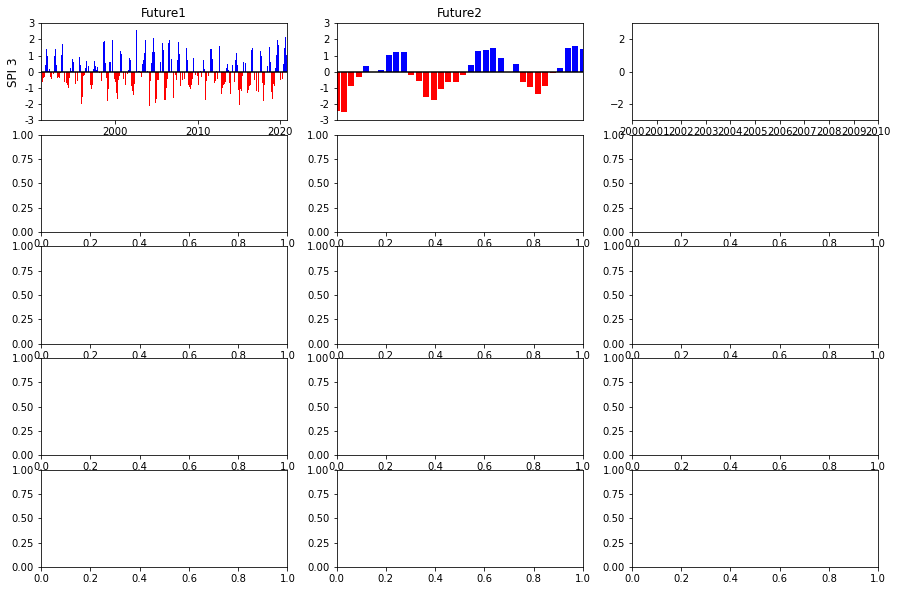

In [58]:
fig, axes = plt.subplots(nrows=5, ncols=3,figsize=(15, 10))
print (list((enumerate(axes))))
plt.subplots_adjust(hspace=0.15)
for i, ax in enumerate(axes):
    for j, a in enumerate(ax):
        d=data[j*30*12:(j+1)*30*12]
        col_scheme=np.where(d['spi_'+str(times[i])]>0, 'b','r')
        a.bar(d.index, d['spi_'+str(times[i])], width=25, align='center', color=col_scheme, label='SPI '+str(times[i]))
        a.set_ylim(-3,3)
        a.set_xlim(d.index[0],d.index[-1])
        a.axhline(y=0, color='k')
        a.xaxis.set_major_locator(mdates.YearLocator(10))
        a.set_yticks(range(-3,4), range(-3,4))
        if j==0:
            a.set_ylabel('SPI '+str(times[i]), fontsize=12)
        if i==0 and j==0:
            a.set_title('Future1', fontsize=12)
        if i==0 and j==1:
            a.set_title('Future2', fontsize=12)
        if i==0 and j==2:
            a.set_title('Future3', fontsize=12)
        if i==4:
            a.set_xlabel('Year', fontsize=12)
fig.tight_layout()

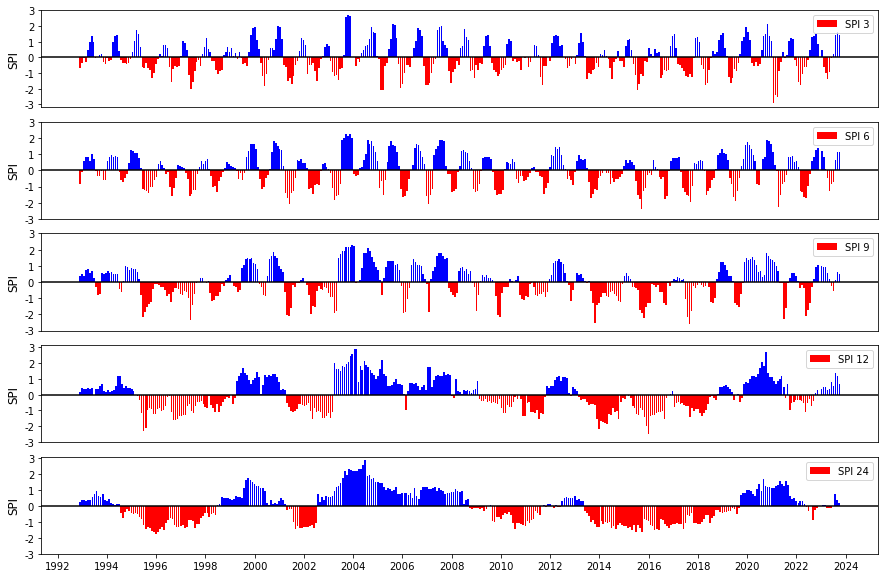

In [59]:
fig, axes = plt.subplots(nrows=5, figsize=(15, 10))
plt.subplots_adjust(hspace=0.15)
for i, ax in enumerate(axes):
    col_scheme=np.where(data['spi_'+str(times[i])]>0, 'b','r')

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.bar(data.index, data['spi_'+str(times[i])], width=25, align='center', color=col_scheme, label='SPI '+str(times[i]))
    ax.axhline(y=0, color='k')
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.legend(loc='upper right')
    ax.set_yticks(range(-3,4), range(-3,4))
    ax.set_ylabel('SPI', fontsize=12)
    
    if i<len(times)-1:
        ax.set_xticks([],[])